In [47]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import glob
import json
import os
from pprint import pprint

In [48]:
results_base = "experiments/results/"
results_dir = "query_expansions"
path = results_base + results_dir

# Get every .json file in every subdir
json_files = glob.glob(os.path.join(path, "**/*.json"), recursive=True)
pprint(json_files)

['experiments/results/query_expansions/basic_bge_chunks_add_prev_7_normTrue_ip_n14735_20250822_160500/results_basic_bge_chunks_add_prev_7_normTrue_ip_n14735_20250822_160500.json',
 'experiments/results/query_expansions/basic_bge_contributions_add_abstract_normTrue_ip_n14735_20250822_162717/results_basic_bge_contributions_add_abstract_normTrue_ip_n14735_20250822_162717.json',
 'experiments/results/query_expansions/basic_bge_chunks_identity_normTrue_ip_n14735_20250822_140157/results_basic_bge_chunks_identity_normTrue_ip_n14735_20250822_140157.json',
 'experiments/results/query_expansions/basic_bge_chunks_add_prev_5_normTrue_ip_n14735_20250822_154925/results_basic_bge_chunks_add_prev_5_normTrue_ip_n14735_20250822_154925.json',
 'experiments/results/query_expansions/basic_bge_chunks_add_prev_3_normTrue_ip_n14735_20250822_153552/results_basic_bge_chunks_add_prev_3_normTrue_ip_n14735_20250822_153552.json',
 'experiments/results/query_expansions/basic_bge_contributions_identity_normTrue_ip_n1

In [49]:
def path_to_label(path):
    filename = os.path.basename(path)
    pieces = filename.split("_")
    model = pieces[2]
    document_rep = pieces[3]
    query_expansion = ""
    if "title" in filename:
        query_expansion = "title"
    elif "abstract" in filename:
        query_expansion = "abstract"
    elif "prev_3" in filename:
        query_expansion = "prev_3"
    elif "prev_5" in filename:
        query_expansion = "prev_5"
    elif "prev_7" in filename:
        query_expansion = "prev_7"

    # Filter out empty strings before joining
    parts = [model, document_rep, query_expansion]
    return "+".join([part for part in parts if part and not part in ['basic']])


names = [path_to_label(filename) for filename in json_files]
for name in sorted(names):
    print(name)

bge+chunks
bge+chunks+abstract
bge+chunks+prev_3
bge+chunks+prev_5
bge+chunks+prev_7
bge+chunks+title
bge+contributions
bge+contributions+abstract
bge+contributions+prev_3
bge+contributions+prev_5
bge+contributions+prev_7
bge+contributions+title


In [50]:
# Build data dict
data = dict()
for file in json_files:
    experiment_results = json.load(open(file))
    hitrates = experiment_results["average_hitrate_at_k"]
    label = path_to_label(file)
    data[label] = hitrates

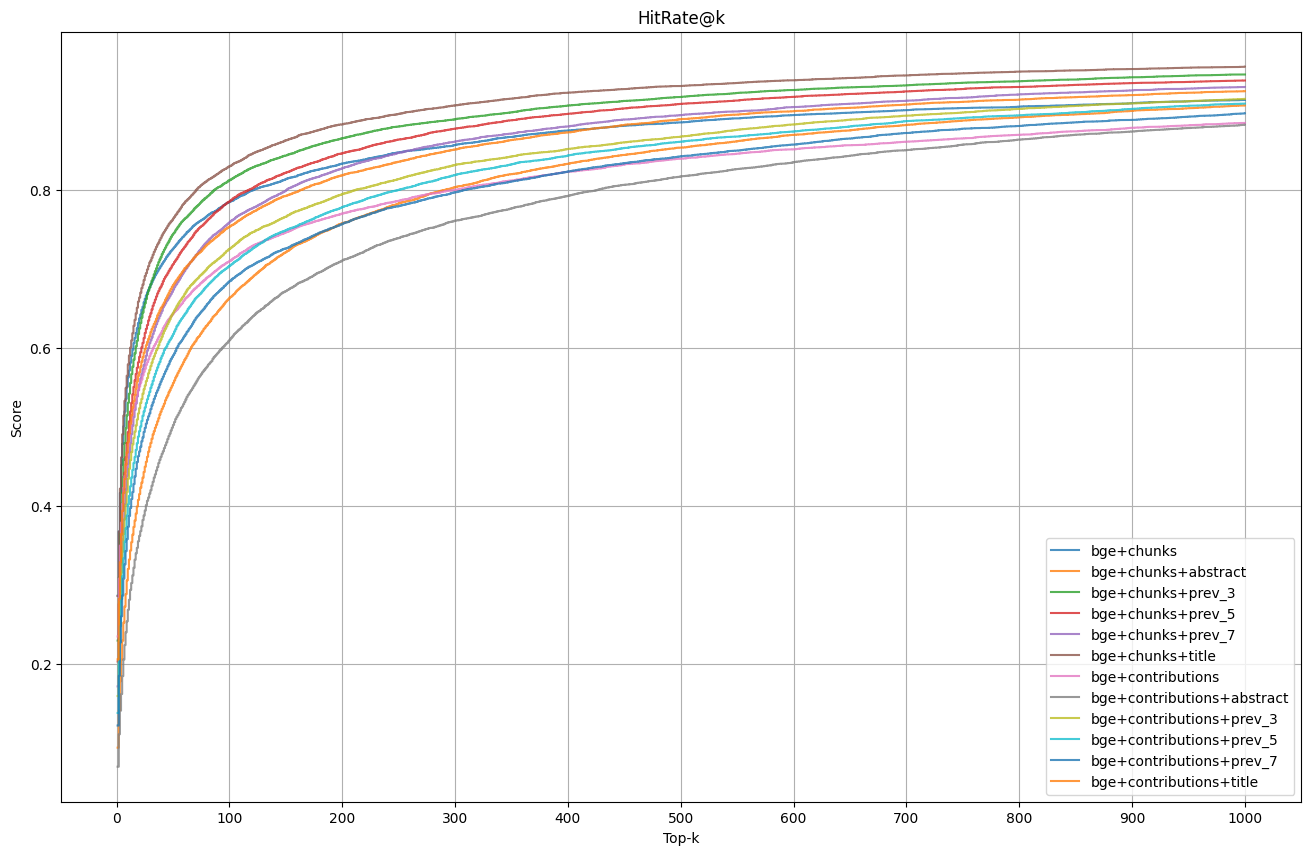

In [51]:
k_values = [k for k in range(1, 1001)]

# Make a plot of the average hit rates (y-axis) and IoU (Jaccard) vs. top-k (x-axis)
plt.figure(figsize=(16, 10))
lines = []
for label, hitrates in sorted(data.items()):
    (line,) = plt.plot(k_values, hitrates, drawstyle="steps-post", linestyle="-", lw=1.5, alpha=0.8, label=label)
    lines.append((line, label, hitrates))

plt.xlabel("Top-k")
plt.ylabel("Score")
plt.title("HitRate@k")
plt.legend()
plt.grid()

# Set x-ticks every 100
plt.gca().xaxis.set_major_locator(MultipleLocator(100))
plt.savefig(f"{results_dir}_k1000.png")
plt.show()
plt.close()

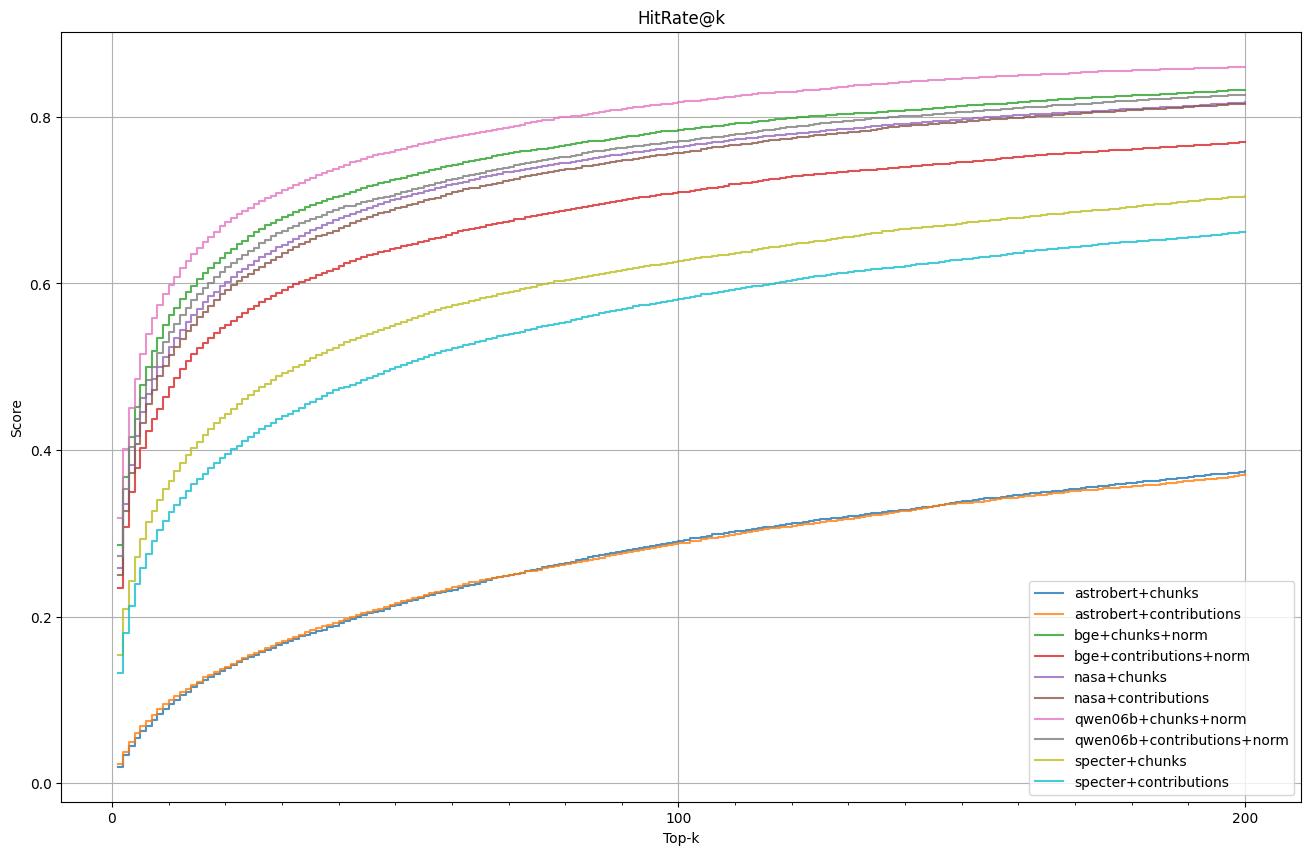

In [22]:
# Repeat the plot but just for k-values 1 through 200
k_values = range(1, 201)
# Make a plot of the average hit rates (y-axis) and IoU (Jaccard) vs. top-k (x-axis)
plt.figure(figsize=(16, 10))
lines = []
for label, hitrates in sorted(data.items()):
    hitrates_trunc = hitrates[:200]
    (line,) = plt.plot(k_values, hitrates_trunc, drawstyle="steps-post", linestyle="-", lw=1.5, alpha=0.8, label=label)
    lines.append((line, label, hitrates))


plt.xlabel("Top-k")
plt.ylabel("Score")
plt.title("HitRate@k")
plt.legend()
plt.grid()

# Set x-ticks every 100
plt.gca().xaxis.set_major_locator(MultipleLocator(100))
plt.gca().xaxis.set_minor_locator(MultipleLocator(10))
plt.savefig(f"{results_dir}_k200.png")
plt.show()
plt.close()